<a href="https://colab.research.google.com/github/chrjohnson26/Network-Science/blob/main/Network_Science_HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

3A. Write a function that accepts two vectors (or lists, or arrays) of node labels and returns the Rand Index. Please carefully organize and comment your code before submitting it.

In [2]:
'''
  The Rand index given two vectors of node labels
'''
def rand_index(pred_label, exp_label):
  # number of nodes
  n = len(exp_label)

  pred_array = np.array(pred_label)
  exp_array = np.array(exp_label)

  # Computing the pairwise delta matries for pred_label and exp_label
  pred_delta = pred_array[:, None] == pred_array[None, :]
  exp_delta = exp_array[:, None] == exp_array[None, :]

  # Calculate delta product, if both elements are one then pairs match in both predictions and ground truth
  delta_product = (pred_delta == exp_delta)

  # Sum the upper triangle portion of delta_product then subtract the diagonal values which are all 1s
  agreeing_pairs = (np.sum(delta_product) - n)/2 # We can divide by 2 since delta_product is symmetric

  # n choose 2
  total_pairs = n*(n-1)/2

  return agreeing_pairs/total_pairs

3B. Demonstrate that your function returns 1 when in an example in which the two label
vectors are exactly the same.
Submit both your code and output.

In [3]:
predicted_labels = [1, 2, 3, 3, 3, 2, 1, 2, 2, 2]
expected_labels  = [1, 2, 3, 3, 3, 2, 1, 2, 2, 2]

# Since predicted_labels and expected_labels have equivalently labeled nodes rande_index should be 1
print(rand_index(predicted_labels, expected_labels))

1.0


Question 4:
(A) Implement binary spectral modularity maximization as a function which accepts a
graph and returns a list or array of node labels. Please carefully organize and comment
your code before submitting it. You may submit code either as a pdf, or provide a
Colab link

In [4]:
import numpy as np
from numpy import linalg as LA
import networkx as nx

'''
  Binary spectral modularity maximization
  Input: Graph G
  Output: List of node labels
'''
def bsmm(G):
  # Getting modularity matrix from graph G
  B = nx.modularity_matrix(G)

  # Finding eigenvector of the modularity matrix
  eigenvalues, eigenvectors = LA.eig(B)

  # Deriving largest eigenvalue's index using argmax
  index = np.argmax(eigenvalues)

  # Corresponding eigenvector for max eigenvalue
  max_eigenvector = eigenvectors[:, index]

  # Assigning nodes to communities according to sign
  communities = [0 if val > 0 else 1 for val in max_eigenvector] # Positive -> 1, Negative -> 0

  return communities

Question 4:
(B) Using your implementation from the previous problem, compute the Rand Index of
your clustering against the labels in the Zachary Karate Club network that comes
packaged with NetworkX. Please show both your code and the output

In [14]:
# Predicted communities

G = nx.karate_club_graph()
pred_communities = bsmm(G) # Calling the bsmm function on the karate club graph
print("Predicted Communities:", end=' ')
print(pred_communities)

# Expected communities (Adapted from Chapter 12 lecture notes)

G_karate = nx.karate_club_graph()
G_karate = nx.convert_node_labels_to_integers(G_karate)
clusters_karate = nx.get_node_attributes(G_karate, "club")
clusters_karate = [0 if club == "Mr. Hi" else 1 for node, club in clusters_karate.items()]
print("Expected Communities:", end='  ')
print(clusters_karate)

# Computing Rand Index of my clustering against the labels in the Zachary karate Club network that comes packaged with NetworkX
rand = rand_index(pred_communities, clusters_karate)
print("Rand Index:           ", end=" ")
print(rand)

Predicted Communities: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Expected Communities:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Rand Index:            0.9411764705882353


(C) Visualize the network using your clustering, coloring nodes according to the cluster labels. Please show both your code and your output

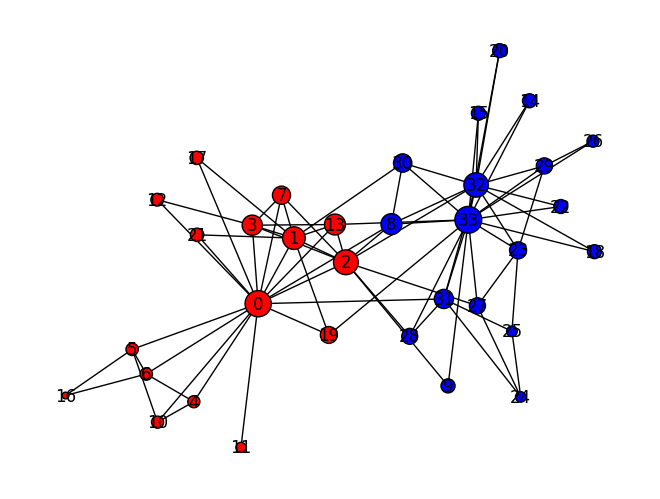

In [6]:
G = nx.karate_club_graph()
comms = bsmm(G) # Calling bsmm function on the Karate Club Graph
eig = nx.eigenvector_centrality(G) # Using centrality measure for node sizing

# Visualization code adapted from https://nbviewer.org/github/PhilChodrow/PIC16B/blob/master/lectures/nx/data-science.ipynb
color_possibilities = ["red", "blue"]
colors = [color_possibilities[comms[j]] for j in G.nodes]
layout = nx.layout.fruchterman_reingold_layout(G)


nx.draw(G, layout,
        with_labels=True,
        node_color = colors,
        node_size  = [1000*eig[i] for i in G.nodes()],
        edgecolors = "black")



5. Generate an GNP graph on 5,000 nodes with mean degree 3, and extract the largest component of this graph. Call the resulting (connected) graph C.

In [7]:
import networkx as nx

# G(n, p) model takes a node size, n, and probability, p, value to generate graph.

# The probability an edge is drawn to a stub is the average degree divided by the number of nodes
c = 3
n = 5000
p = c/n

G = nx.erdos_renyi_graph(n, p) # Generating an erdos renyi graph from the derived parameters

max_component = max(nx.connected_components(G), key = len) # Using the built in networkX function to find the largest component
C = G.subgraph(max_component).copy() # Setting graph C equal to the max_component

# Print information about C
print("Number of nodes in C:", C.number_of_nodes())
print("Number of edges in C:", C.number_of_edges())

Number of nodes in C: 4706
Number of edges in C: 7469


(A) Use your binary spectral modularity maximization algorithm from the previous problem to find a label vector g for C.

In [8]:
g = bsmm(C) # Calculating the binary spectral modularity maximization for C

(B) Compute the modularity of the label vector g in C. Please show both your code and your output.

In [9]:
# Using the modularity function defined in lecture
def modularity(G, z):

    # converts z from a dict to an array if it isn't one already
    z = np.array(z)

    # form the matrices we need
    A = nx.to_numpy_array(G)
    k = A.sum(axis = 1)
    m = G.number_of_edges()

    # computes a matrix whose ith entry is delta_{z_i, z_j}
    delta = z[:, None] == z[None, :]

    return 1/(2*m)*((A - np.outer(k, k) / (2 * m))*delta).sum()

In [10]:
print(modularity(C, g))

0.25606549110088866
